In [1]:
## LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('divvy.csv')

### DATA CLEANING

In [3]:
df.duplicated().sum()

0

In [4]:
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [5]:
import datetime
df["started_at"] = pd.to_datetime(df["started_at"])
df["ended_at"] = pd.to_datetime(df["ended_at"])

In [6]:
(df.isnull().sum()/df.shape[0]*100)

ride_id                0.000000
rideable_type          0.000000
started_at             0.000000
ended_at               0.000000
start_station_name    15.410144
start_station_id      15.410144
end_station_name      16.271756
end_station_id        16.271756
start_lat              0.000000
start_lng              0.000000
end_lat                0.162889
end_lng                0.162889
member_casual          0.000000
dtype: float64

In [7]:
df.shape

(771693, 13)

In [8]:
df['start_station_name'].mode()

0    Streeter Dr & Grand Ave
Name: start_station_name, dtype: object

In [9]:
df['end_station_name'].mode()

0    Streeter Dr & Grand Ave
Name: end_station_name, dtype: object

In [10]:
df['start_station_name'].fillna('Streeter Dr & Grand Ave', inplace=True)
df['end_station_name'].fillna('Streeter Dr & Grand Ave', inplace=True)

In [11]:
df['end_station_id'].mode()

0    13022
Name: end_station_id, dtype: object

In [12]:
df['start_station_id'].mode()

0    13022
Name: start_station_id, dtype: object

In [13]:
df['start_station_id'].fillna(13022, inplace=True)
df['end_station_id'].fillna(13022, inplace=True)

In [14]:
df.dropna(inplace=True)

In [15]:
df.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64

In [16]:
def drop_outlier(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [17]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,903C30C2D810A53B,electric_bike,2023-08-19 15:41:53,2023-08-19 15:53:36,LaSalle St & Illinois St,13430,Clark St & Elm St,TA1307000039,41.890721,-87.631477,41.902973,-87.63128,member
1,F2FB18A98E110A2B,electric_bike,2023-08-18 15:30:18,2023-08-18 15:45:25,Clark St & Randolph St,TA1305000030,Streeter Dr & Grand Ave,13022,41.884511,-87.631550,41.930000,-87.64000,member
2,D0DEC7C94E4663DA,electric_bike,2023-08-30 16:15:08,2023-08-30 16:27:37,Clark St & Randolph St,TA1305000030,Streeter Dr & Grand Ave,13022,41.884981,-87.630793,41.910000,-87.63000,member
3,E0DDDC5F84747ED9,electric_bike,2023-08-30 16:24:07,2023-08-30 16:33:34,Wells St & Elm St,KA1504000135,Streeter Dr & Grand Ave,13022,41.903105,-87.634667,41.900000,-87.62000,member
4,7797A4874BA260CA,electric_bike,2023-08-22 15:59:44,2023-08-22 16:20:38,Clark St & Randolph St,TA1305000030,Streeter Dr & Grand Ave,13022,41.885548,-87.632019,41.890000,-87.68000,member


### BUSINESS INFORMATION AND FEATURE ENGINEERING

In [18]:
df["hour"] = df["started_at"].dt.hour
df["minute"] = df["started_at"].dt.minute
df["num_week"] = df["started_at"].dt.dayofweek
df['day_of_week'] = df['started_at'].dt.day_name()
df["month"] = df["started_at"].dt.month

In [19]:
## PRICING
df['ride_category'] = 'paying'
df['ride_duration']=df['ended_at']-df['started_at']
df['ride_duration']=df['ride_duration'].apply(lambda x:int(x.total_seconds())/60)
df.loc[df['ride_duration'] <= 45, 'ride_category'] = 'free ride'

Text(0, 0.5, 'Count')

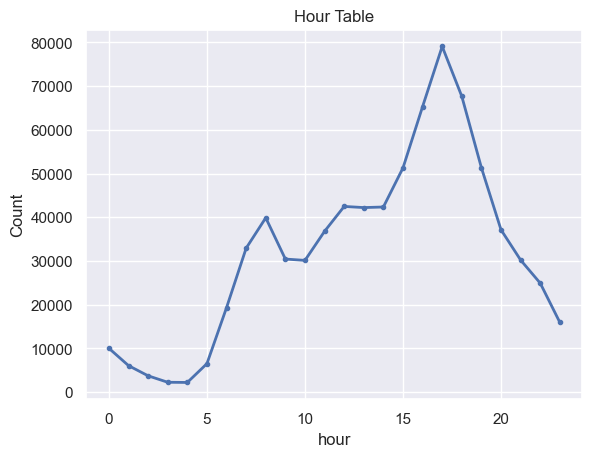

In [20]:
## PEAK AND OFF-PEAK TIMES
df['ride_time_category'] = 'Off-Peak'

hour_ct = df['hour'].value_counts().to_frame().reset_index()
hour_ct.sort_values(by='hour', inplace = True)

x = hour_ct['hour']
y = hour_ct['count']
plt.plot(x,y, color = "b", lw=2, marker = "o", ms = "3")
plt.title("Hour Table")
plt.xlabel("hour")
plt.ylabel("Count")

In [21]:
peak_hours_start = 5
peak_hours_end = 17

df.loc[(df['started_at'].dt.hour >= peak_hours_start) & (df['started_at'].dt.hour 
<= peak_hours_end), 'ride_time_category'] = 'Peak'


In [22]:
### WEEKENDS AND WEEKDAYS
df['ride_day_category'] = 'Weekday'
df.loc[df['started_at'].dt.dayofweek >= 5, 'ride_day_category'] = 'Weekend'

### Exploratory Data Analysis

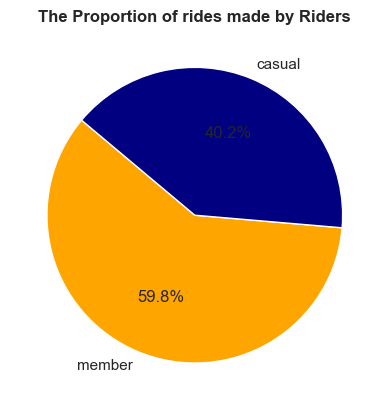

In [23]:
#1. What is the proportion of rides made by members compared to casual users?
mem_cas = df['member_casual'].value_counts().to_frame()
mem_cas.reset_index(inplace=True)
values = mem_cas['count']
labels = mem_cas['member_casual']
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['orange', 'navy'])
plt.title('The Proportion of rides made by Riders', fontsize = 12, fontweight="bold")
plt.show()

<Figure size 1000x600 with 0 Axes>

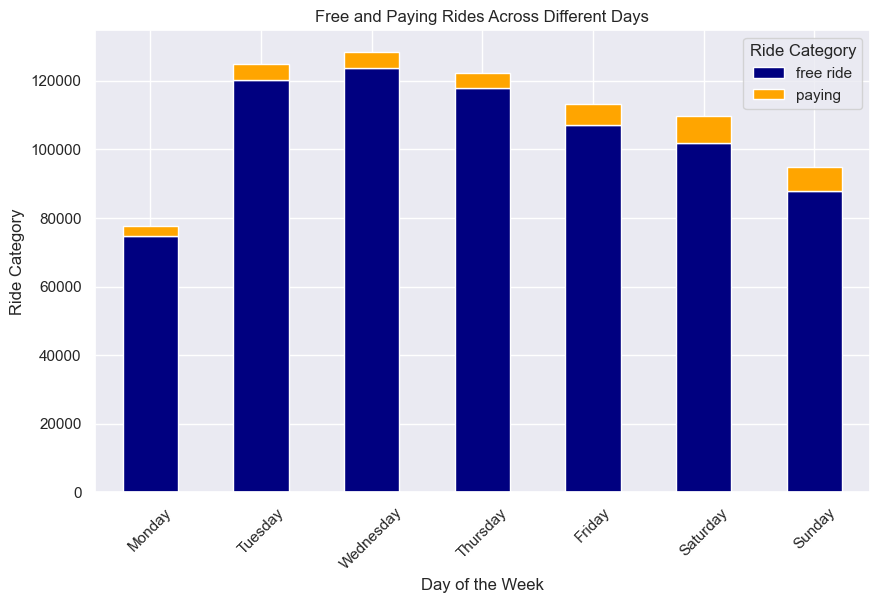

In [24]:
#2. Do the proportions of free and paying rides change during different days of the week?
ridecat_dayweek =  df.groupby(['day_of_week', 'ride_category']).size().reset_index(name = 'count')
ridecat_dayweek = ridecat_dayweek.pivot(index='day_of_week', columns='ride_category', values='count')
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ridecat_dayweek = ridecat_dayweek.reindex(days)
plt.figure(figsize=(10, 6))
ridecat_dayweek.plot(kind='bar', stacked=True, color=['navy', 'orange'], figsize=(10, 6))
plt.title('Free and Paying Rides Across Different Days')
plt.xlabel('Day of the Week')
plt.ylabel('Ride Category')
plt.legend(title='Ride Category')
plt.xticks(rotation=45)
plt.show()

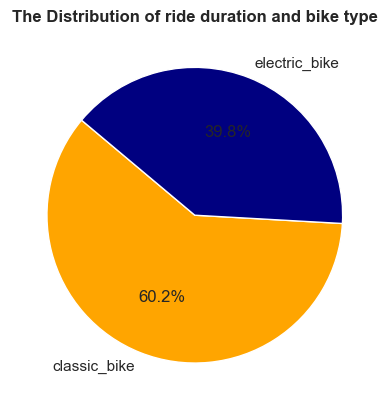

In [25]:
#3. How does the distribution of ride durations vary between electric bikes and classic bikes
ride_dur_type = df.groupby('rideable_type')['ride_duration'].sum().to_frame().reset_index()
ride_dur_type.drop(1, axis=0,inplace=True)
#x = ride_dur_type['rideable_type']
#y = ride_dur_type['ride_duration']
values = ride_dur_type['ride_duration']
labels = ride_dur_type['rideable_type']
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['orange', 'navy'])
plt.title('The Distribution of ride duration and bike type', fontsize = 12, fontweight="bold")
plt.show()

In [26]:
#4. Which start station has the highest average ride duration?

start_dur = df.groupby("start_station_name")['ride_duration'].mean().reset_index().sort_values(by="ride_duration", ascending=False).head(3)
start_dur

,start_station_name,ride_duration
184,Commercial Ave & 100th St,178.019048
1027,Racine Ave & 61st St,160.894444
1028,Racine Ave & 65th St,135.319048


#### Commercial Ave & 100th St has the highest ride duration as seen in the table above

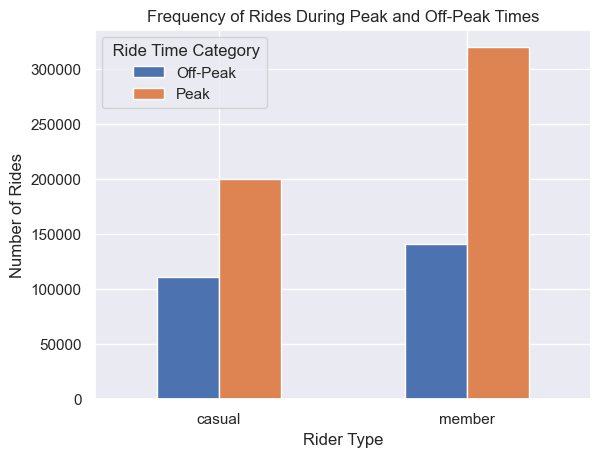

In [27]:
#5.Visualize the frequency of rides for member and casual riders during peak and off-peak times.
memcas_peak = df.groupby(['member_casual', 'ride_time_category']).size().unstack()
memcas_peak.plot(kind='bar', stacked=False)
plt.title('Frequency of Rides During Peak and Off-Peak Times')
plt.xlabel('Rider Type')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.legend(title=' Ride Time Category')
plt.show()

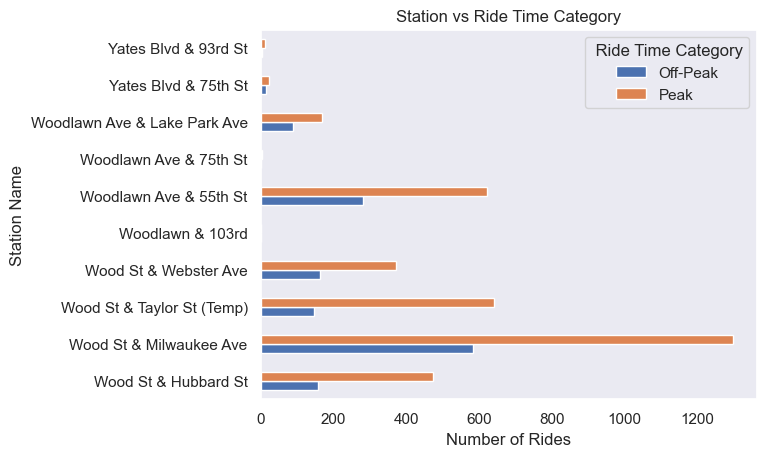

In [28]:
#6. Are certain stations more popular during peak hours compared to off-peak hours?

station_peak =  pd.crosstab(df['end_station_name'], df['ride_time_category'])
station_peak = station_peak.tail(10)
station_peak.plot(kind='barh', stacked=False)
plt.title('Station vs Ride Time Category')
plt.xlabel('Number of Rides')
plt.ylabel('Station Name')
plt.xticks(rotation=0)
plt.legend(title=' Ride Time Category')
plt.grid()


#### Most stations are more popular during Peak hours than at Off-Peak hours

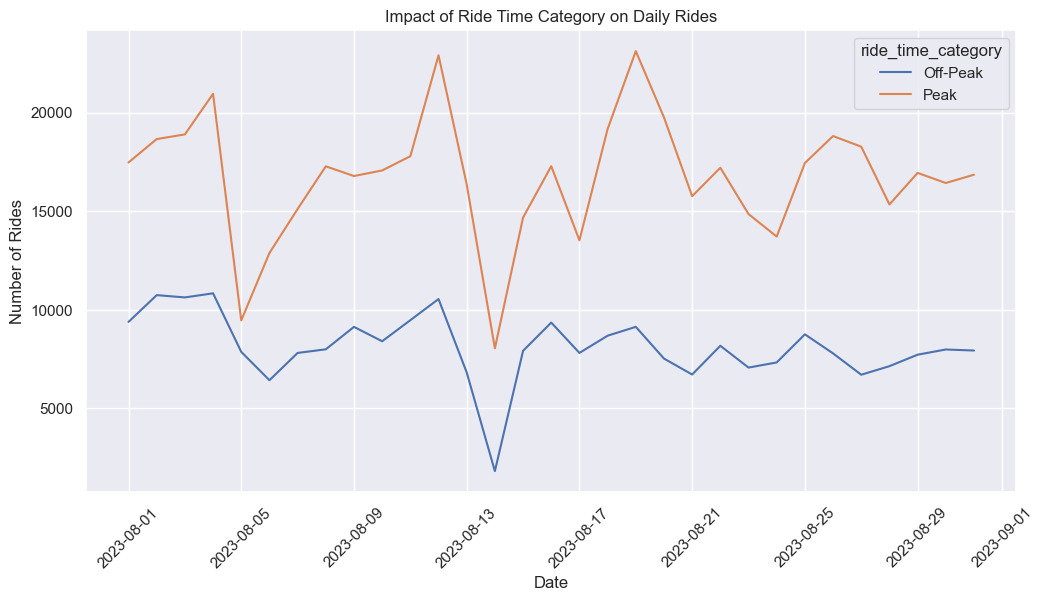

In [29]:
#7. How does the categorization of rides into peak and off-peak times impact daily rides?
df['date'] = df['started_at'].dt.date
dailyrides_timecat = df.groupby(['date', 'ride_time_category']).size().reset_index(name='number_of_rides')
daily_rides_pivot = dailyrides_timecat.pivot(index='date', columns='ride_time_category', values='number_of_rides')
daily_rides_pivot.plot(kind='line', figsize=(12, 6))
plt.title('Impact of Ride Time Category on Daily Rides')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.show()

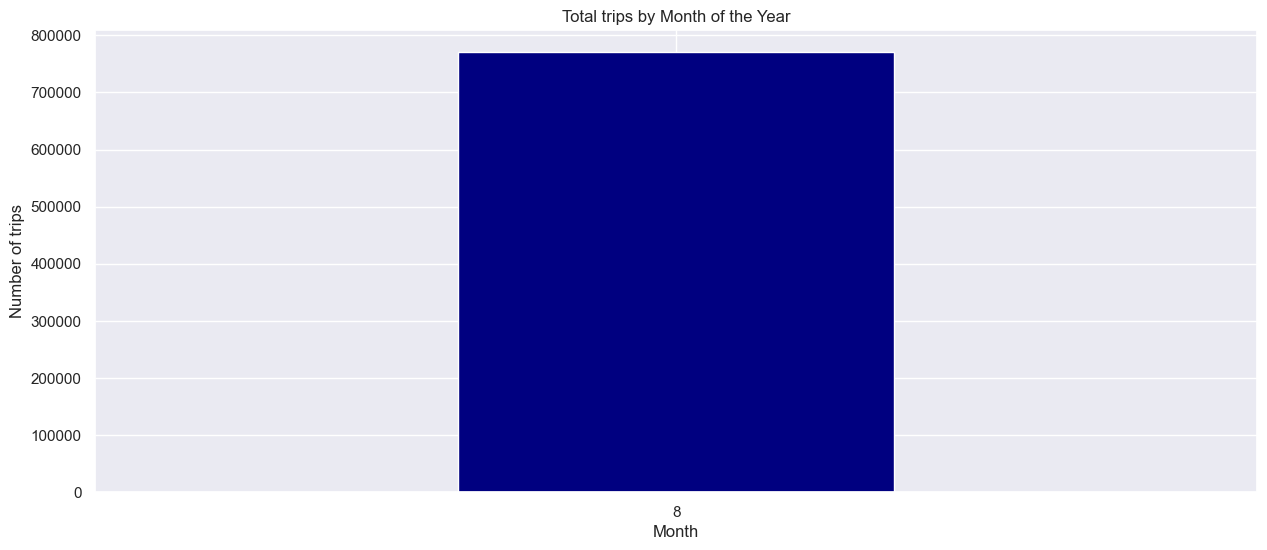

In [30]:
#8. Visualize the number of trips by month of the year.
plt.figure(figsize=(15, 6)) 
df.month.value_counts().plot(kind='bar',color="navy",align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("Month")
plt.ylabel("Number of trips")
plt.title("Total trips by Month of the Year");

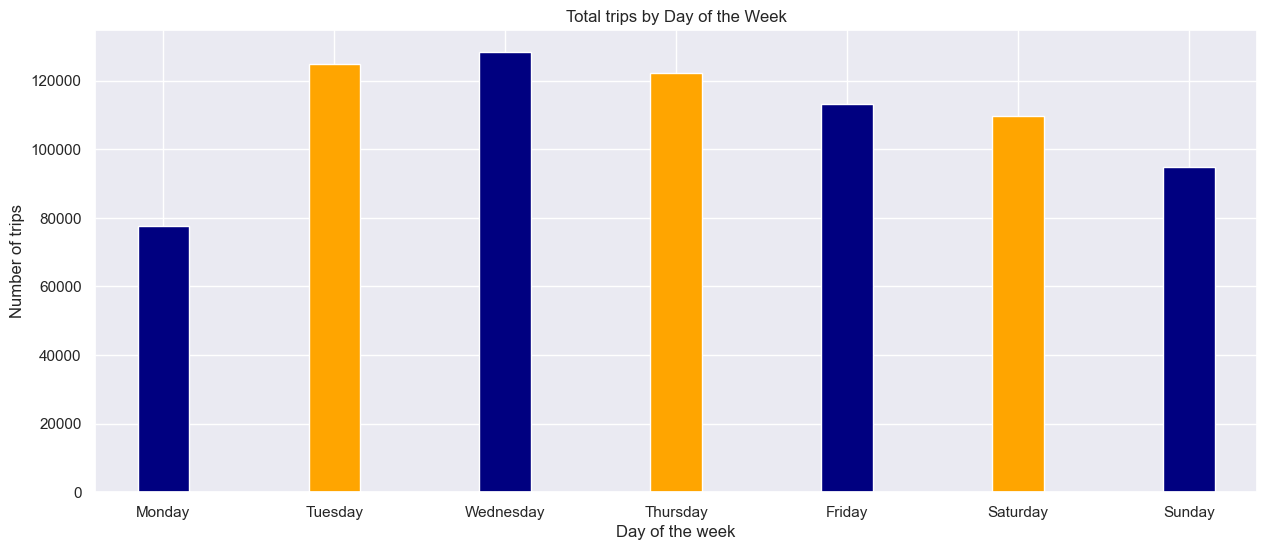

In [31]:
#9. Visualize the number of trips by day of the week.
plt.figure(figsize=(15, 6)) 
df.day_of_week.value_counts().reindex(days).plot(kind='bar',color=("navy", "orange"), align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("Day of the week")
plt.ylabel("Number of trips")
plt.title("Total trips by Day of the Week");

<Figure size 2500x600 with 0 Axes>

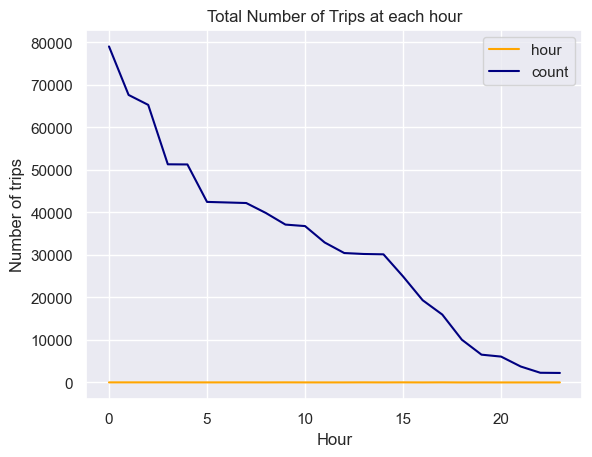

In [32]:
#10. Visualize the number of trips by hour of the day.
plt.figure(figsize=(25, 6)) 
df.hour.value_counts().reset_index().plot(kind='line',color=["orange","navy"],lw=1.5)
plt.xlabel("Hour")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total Number of Trips at each hour");
